# Collaborative Filtering

A popular recommendation system designed by Netflix which recommends items to user based on items that similar users enjoy is called Collaborative Filtering. Usually, value used to compare similarities are ratings provided by users. However, this dataset doesn't have any feedback like that. The most we have is the number of hours on played on each game, which although there isn't the best or direct insight still provides some information about how the user feels towards the game. Since its unclears how to turn play hours into a rating, multiple metrics will be created to act as the rating. 

Different Metrics to replace Rating:
- Raw Hours played
- Sigmoid of Z-score of hours played using user avg and std
- Possion CDF score using game avg and std
- 0-1 if they played it or not
- 0-1 if they purchased it or not

It'll also be good to experiment with combining the last two metrics somehow.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.special import expit
from timeit import default_timer

dtype_dict_games = {'buyer-count': 'int64',
 'player-count': 'int64',
 'accumulated-hours-played': 'float64',
 'player-frac-of-buyer': 'float64',
 'avg-hours-played': 'float64',
 'std-hours-played': 'float64'}

dtype_dict_users = {'purchased-game-count': 'int64',
 'played-game-count': 'int32',
 'played-hours-count': 'float64',
 'purhased-gametitles-list': 'object',
 'played-gametitles-list': 'object',
 'percent-library-played': 'float64',
 'played-hours-avg': 'float64',
 'played-hours-std': 'float64',
 'played-hours-max': 'float64',
 'most-played-game': 'object'}

games_stats_df = pd.read_csv('./steam_game_aggregate_data.CSV', index_col= 0,dtype=dtype_dict_games)
users_stats_df = pd.read_csv('./steam_user_aggregate_data.CSV', index_col= 0,dtype=dtype_dict_users)

## 1. Raw Hours Played

The original data is going to be needed to loop through and insert values into a sparse matrix. The matrix we're making will contain the information associated to a user's opinion of a game. Since most of the cells will be empty, it makes sense to loop through the played_df we made in an earlier notebook.

In [3]:
#names to assign to columns
column_names = ['user-id','game-title','behavior-name','value']

#dtypes to assign
dtypes = {'user-id':int, 'game-title':str, 'behavior-name':'category', 'value':np.float64}

#read in data from csv (please adjust path if you want to run this). Dropped last column because useless
df = pd.read_csv('./steam-200k.csv', 
                usecols=[0,1,2,3],
                names=column_names)

play_mask = df['behavior-name'] == 'play'
play_df = df[play_mask]

The next cell creates a large empty dataframe that the size of (#ofUsers)x(#ofGames).

In [4]:
full_game_list = games_stats_df.index.to_list()
full_user_list = users_stats_df.index.to_list()
hours_played_matrix = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

Going through every recording of hours played on each game, we insert the number of hours into each cell accordingly

In [5]:
for ind, row in play_df.iterrows():
    hours_played_matrix.at[int(row['user-id']), row['game-title']] = row['value']    

Next, cosine similarity is going to be calculated using a function in the scikit-learn machine learning library. This accepts sparse arrays created using scipy's csr_matrix() function (i.e, CSR = Compress Sparse Row)

In [6]:
hours_played_matrix_sparse = sparse.csr_matrix(hours_played_matrix.fillna(0).values.T)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(hours_played_matrix_sparse)

similarity_df = pd.DataFrame(similarities, columns=full_game_list, index=full_game_list)

We're going to see what are the recommendation for popular valve game, 'Team Fortress 2".

In [8]:
similarity_df['Team Fortress 2'].sort_values(ascending=False)

Team Fortress 2                                   1.000000
Poker Night at the Inventory                      0.166778
Thief Town                                        0.140406
Eidolon                                           0.140406
Super Game Jam                                    0.140406
                                                    ...   
Planetside 2 Elite Soldier Bundle                 0.000000
Planets Under Attack                              0.000000
Planetary Annihilation - Original Soundtrack      0.000000
Planetary Annihilation - Digital Deluxe Bundle    0.000000
007 Legends                                       0.000000
Name: Team Fortress 2, Length: 5155, dtype: float64

The recommendation system didn't work well, but this is likely because raw hours were used instead of standardized values. Below a histogram of the hours values are shown, showing a deep skew right.

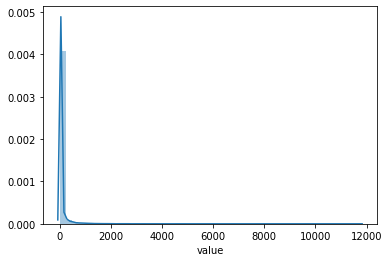

In [9]:
import seaborn as sns

sns.distplot(play_df['value'])

## 2.Sigmoid or Z-Scores (Calculated with User statistics)

This next method is going to use a sigmoid function because we want to map a domain of [0,$\infty$) to a domain of [0,1]. However, the middle score is at ln2(=0.693) hours, when it'd be better to have it at the mean hours that the user typical plays games.

The idea here is if a user spent more time than they usually do playing game, they "must" have liked it, while a game that they quit quickly wasn't meant for them. The biggest short coming is that there are some games are designed to be beat in a short amount of time, but users would still rate the game well dispite the short playtime.

In [10]:
def zScore(val, mean, std):
    return (val-mean)/std

def zigmoid(row):
    user_stats = users_stats_df.loc[row['user-id']]
    mean = user_stats['played-hours-avg']
    std = user_stats['played-hours-std']
    return expit(zScore(row['value'], mean, std))

def zigTanh(row):
    return 2.0*zigmoid(row) - 1.0
 
play_df['zigmoid'] = play_df.apply(lambda x: zigTanh(x), axis=1)

C:\Users\alexr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\alexr\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Displaying the distribution below with seaborn shows there still a strong skew to the right.

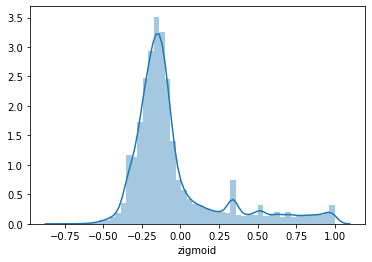

In [11]:
sns.distplot(play_df['zigmoid'])

In [12]:
play_df['zigmoid'].describe()

count    63892.000000
mean        -0.040597
std          0.302212
min         -0.777935
25%         -0.212951
50%         -0.134768
75%         -0.021701
max          1.000000
Name: zigmoid, dtype: float64

Since its clear anything scoring over 60 is generally liked, and not necessarily liked more than a game scoring 80, thus a "cieling" will be put on 60.

In [12]:
hours_played_matrix_zig = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

for ind, row in play_df.iterrows():
    hours_played_matrix_zig.at[int(row['user-id']), row['game-title']] = row['zigmoid']

In [13]:
#47.97 was average from distribution
for ind, row in hours_played_matrix_zig.iterrows():
    #impute_mean = users_stats_df['played-hours-avg'][ind]
    row.fillna(0, inplace=True)

In [14]:
hours_played_matrix_zig_sparse = sparse.csr_matrix(hours_played_matrix_zig.values.T)

In [15]:

#this code takes a bit so I wanted to know how long for future testing
start_time = default_timer()
# code you want to evaluate
elapsed = default_timer() - start_time
#games_stats_df.loc[play_df.iloc[1]['game-title']]

#creates array of similarity scores
similarities = cosine_similarity(hours_played_matrix_zig_sparse)

#puts array into pandas dataframe
similarity_df = pd.DataFrame(similarities, columns=full_game_list, index=full_game_list)


elapsed = default_timer() - start_time
print("Similarity df took {:.2f} second(s) to compute".format(elapsed))

Similarity df took 0.11 second(s) to compute


In [16]:
similarity_df['Left 4 Dead 2'].sort_values(ascending=False)[:10]

Left 4 Dead 2                    1.000000
Left 4 Dead                      0.181096
Saints Row The Third             0.123025
Bad Hotel                        0.111868
Space Pirates and Zombies        0.111196
Rebuild 3 Gangs of Deadsville    0.111025
A.R.E.S. Extinction Agenda EX    0.109431
Adventurer Manager               0.109431
Hidden Object Bundle 4 in 1      0.108206
Sleeping Dogs                    0.103616
Name: Left 4 Dead 2, dtype: float64

# 3.Possion CDF (Calculated with Game Statistics)

In this approach, a possion cummulative distribution function (cdf) is used to rank if a game was played more than usual or less than usual (using game statistics).

In [31]:
from scipy.stats import poisson

def possionCDFScore(row):
    game_stats = games_stats_df.loc[row['game-title']]
    mean = game_stats['avg-hours-played']
    return poisson.cdf(row['value'], mean)

In [32]:
hours_played_matrix_pos = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)


#this code takes a bit so I wanted to know how long for future testing
start_time = default_timer()

play_df['possioncdf'] = play_df.apply(lambda row: possionCDFScore(row), axis=1)

elapsed = default_timer() - start_time
print("Possion column construction took {:.2f} second(s) to compute".format(elapsed))

for ind, row in play_df.iterrows():
    hours_played_matrix_pos.at[int(row['user-id']), row['game-title']] = row['possioncdf']

C:\Users\alexr\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Possion column construction took 22.10 second(s) to compute


Checking out the distibution below actually reveals that the majority of scores returned were near 0 or near 1 with quite few values being in between.

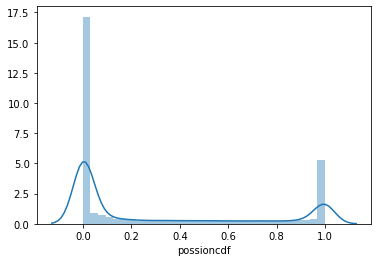

In [34]:
sns.distplot(play_df['possioncdf'])

In [33]:
#47.97 was average from distribution
for ind, row in hours_played_matrix_pos.iterrows():
    #impute_mean = users_stats_df['played-hours-avg'][ind]
    row.fillna(0, inplace=True)

In [36]:
hours_played_matrix_pos_sparse = sparse.csr_matrix(hours_played_matrix_pos.values.T)

In [37]:
from timeit import default_timer
#this code takes a bit so I wanted to know how long for future testing
start_time = default_timer()
# code you want to evaluate
elapsed = default_timer() - start_time
#games_stats_df.loc[play_df.iloc[1]['game-title']]

similarities = cosine_similarity(hours_played_matrix_pos_sparse)

similarity_df = pd.DataFrame(similarities, columns=full_game_list, index=full_game_list)


elapsed = default_timer() - start_time
print("Similarity df took {:.2f} second(s) to compute".format(elapsed))

Similarity df took 0.11 second(s) to compute


In [38]:
similarity_df['Borderlands'].sort_values(ascending=False)[:10]

Borderlands                     1.000000
Borderlands 2                   0.358876
Divinity II Developer's Cut     0.270248
Frontlines Fuel of War          0.247579
Talisman Digital Edition        0.237968
Sanctum                         0.225719
Space Trader Merchant Marine    0.222318
Stormrise                       0.220525
Portal                          0.220023
Portal 2                        0.216129
Name: Borderlands, dtype: float64

Looking At the distribution of values, it appears that using 0-1 encoding created the best recommendation engine, but it isn't great by any means. We can build a quick model using whether the user played a game or not.

In [41]:
hours_played_matrix_oh = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

for ind, row in play_df.iterrows():
    hours_played_matrix_oh.at[int(row['user-id']), row['game-title']] = 1
    
#47.97 was average from distribution
for ind, row in hours_played_matrix_oh.iterrows():
    #impute_mean = users_stats_df['played-hours-avg'][ind]
    row.fillna(0, inplace=True)
    
hours_played_matrix_oh_sparse = sparse.csr_matrix(hours_played_matrix_oh.values.T)

Possion column construction took 0.00 second(s) to compute


In [42]:
similarities = cosine_similarity(hours_played_matrix_oh_sparse)

similarity_df = pd.DataFrame(similarities, columns=full_game_list, index=full_game_list)


elapsed = default_timer() - start_time
print("Similarity df took {:.2f} second(s) to compute".format(elapsed))

Similarity df took 0.10 second(s) to compute


In [45]:
similarity_df['FTL Faster Than Light'].sort_values(ascending=False)[:10]

FTL Faster Than Light    1.000000
XCOM Enemy Unknown       0.407221
Bastion                  0.396169
Prison Architect         0.377964
Gunpoint                 0.361296
Rogue Legacy             0.347941
Hotline Miami            0.339979
Mark of the Ninja        0.338326
Frozen Synapse           0.331957
The Stanley Parable      0.331283
Name: FTL Faster Than Light, dtype: float64

It turns out that not trying to complicate things worked out pretty well and requires very little time to compute comparatively. Since this isn't hard to build, another will be made using purchasing.

In [24]:
purch_mask = df['behavior-name'] == 'purchase'
purch_df = df[purch_mask]

hours_played_matrix_purch = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

for ind, row in purch_df.iterrows():
    hours_played_matrix_purch.at[int(row['user-id']), row['game-title']] = 1
    
for ind, row in hours_played_matrix_purch.iterrows():
    row.fillna(0, inplace=True)
    
hours_played_matrix_purch_sparse = sparse.csr_matrix(hours_played_matrix_purch.values.T)

start_time = default_timer()

similarities = cosine_similarity(hours_played_matrix_purch_sparse)

similarity_df = pd.DataFrame(similarities, columns=full_game_list, index=full_game_list)

elapsed = default_timer() - start_time
print("Similarity df took {:.2f} second(s) to compute".format(elapsed))

Similarity df took 0.22 second(s) to compute


In [33]:
similarity_df['Left 4 Dead 2'].sort_values(ascending=False)[:10]

Left 4 Dead 2                      1.000000
Portal 2                           0.450459
Left 4 Dead                        0.437185
Borderlands 2                      0.402359
Counter-Strike Global Offensive    0.396100
Portal                             0.379786
Garry's Mod                        0.369404
Half-Life 2 Episode Two            0.368318
Grand Theft Auto IV                0.365610
Killing Floor                      0.362689
Name: Left 4 Dead 2, dtype: float64

The results turned out pretty good, similar to the one based on whether or not a user played a game. Although, free games are definetly more likely to recommend other free games using this model.